In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import pandas as pd
import zipfile 
import urllib
import os
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-12 20:00:08--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip.3”

100%[======================================>] 611,524     --.-K/s   in 0.07s   

2017-12-12 20:00:08 (8.17 MB/s) - “zbp94totals.zip.3” saved [611524/611524]

--2017-12-12 20:00:08--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp95totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625328 (611K) [application/zip]
Saving to: “zbp95totals.zip.3”

100%[======================================>] 625,328      680K/s   in 0.9s    

2017-12-12 20:00:

100%[======================================>] 660,109     --.-K/s   in 0.1s    

2017-12-12 20:00:15 (4.44 MB/s) - “zbp09totals.zip.2” saved [660109/660109]

--2017-12-12 20:00:15--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip.2”

100%[======================================>] 797,534     --.-K/s   in 0.04s   

2017-12-12 20:00:15 (18.2 MB/s) - “zbp10totals.zip.2” saved [797534/797534]

--2017-12-12 20:00:15--  https://www2.census.gov/econ2011/CBP_CSV/zbp11totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 795390 (777K) [application/zip

In [3]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

--2017-12-12 20:00:34--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-12 20:00:34--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.1”

100%[======================================>] 1,514,401   1.97M/s   in 0.7s    

2017-12-12 20:00:35 (1.97 MB/s) - “application%2Fzip.1” saved [1514401/1514401]



In [4]:
frames = []
for i in range(94,100):
    fname = 'zbp' + str(i) + "totals.zip"
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df = df[df.zip.astype(str).str.startswith('1')]
    #df.zip = df.zip.apply(add_zeros)
    df.set_index('zip', inplace=True)
    df = df['est'].rename('19' + str(i))
    frames.append(df)

for i in range(0,15):
    fname = 'zbp' + str(i).zfill(2) + "totals.zip"
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [x.lower() for x in df.columns]
    df = df[df.zip.astype(str).str.startswith('1')]
    #df.zip = df.zip.apply(add_zeros)
    df.set_index('zip', inplace=True)
    df = df['est'].rename('20' + str(i).zfill(2))
    frames.append(df)

In [5]:
df = pd.concat(frames, axis=1)
#del df.index.name

In [6]:
url = "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
urllib.request.urlretrieve(url, 'nyc.zip')
os.system("unzip -d %s nyc.zip"%(os.getenv("PUIDATA")))

nycshp = gpd.GeoDataFrame.from_file((os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp"))

In [7]:
nycshp.ZIPCODE = nycshp.ZIPCODE.astype(int)

In [8]:
df["ZIPCODE"] = df.index

In [9]:
df = df.merge(nycshp, on="ZIPCODE")

In [10]:
df.set_index("ZIPCODE", inplace=True)

In [38]:
# 2 K Means Clustering

In [11]:
cluster = df.ix[:,:21]

In [12]:
cluster = cluster.dropna()

In [13]:
for i in range(0,len(cluster.columns)):
    ts = np.asarray(cluster.ix[:,i])
    mean = ts.mean()
    std = ts.std()
    for j in range(0,len(ts)):
        ts[j] = (ts[j] - mean)/std
    cluster.ix[:,i] = ts

In [16]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K Means clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for K Means clustering')
    plt.show()

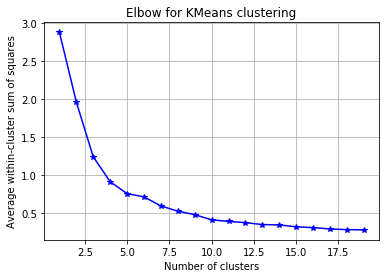

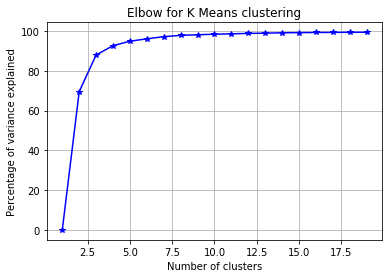

In [17]:
elbow(cluster,range(1,20))

In [18]:
clusterer = KMeans(n_clusters=3, random_state=324)
cluster_labels = clusterer.fit_predict(cluster)
cluster['cluster_labels'] = cluster_labels

In [19]:
cluster["ZIPCODE"] = cluster.index

In [20]:
df = df.join(cluster.cluster_labels)

In [21]:
df = gpd.GeoDataFrame(df)

Text(0.5,1,'Clusters: K Means')

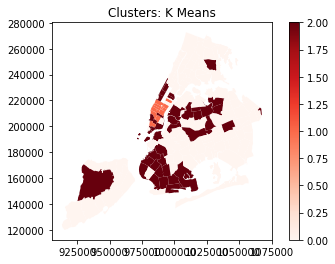

In [22]:
df.plot(column='cluster_labels', cmap='Reds', legend=True)
plt.title("Clusters: K Means")

In [23]:
cluster_label_group = df.groupby("cluster_labels").mean()

In [24]:
cluster_label_group.ix[:,0:21]

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0.0,341.055814,346.162791,351.697674,359.744186,364.432558,367.795349,371.865116,371.158140,384.906977,391.734884,...,400.353488,402.311628,407.906977,412.688372,419.339535,428.753488,435.911628,445.786047,457.013953,466.162791
1.0,5317.000000,5455.909091,5461.818182,5577.727273,5616.181818,5600.545455,5690.454545,5695.272727,5487.363636,5475.818182,...,5581.363636,5618.909091,5510.363636,5483.181818,5387.727273,5358.363636,5345.909091,5360.272727,5387.909091,5404.454545
2.0,1388.192982,1413.526316,1437.368421,1482.157895,1506.807018,1538.350877,1581.245614,1580.263158,1615.035088,1638.701754,...,1682.087719,1701.228070,1727.385965,1742.456140,1756.894737,1792.245614,1819.157895,1859.596491,1900.894737,1947.350877


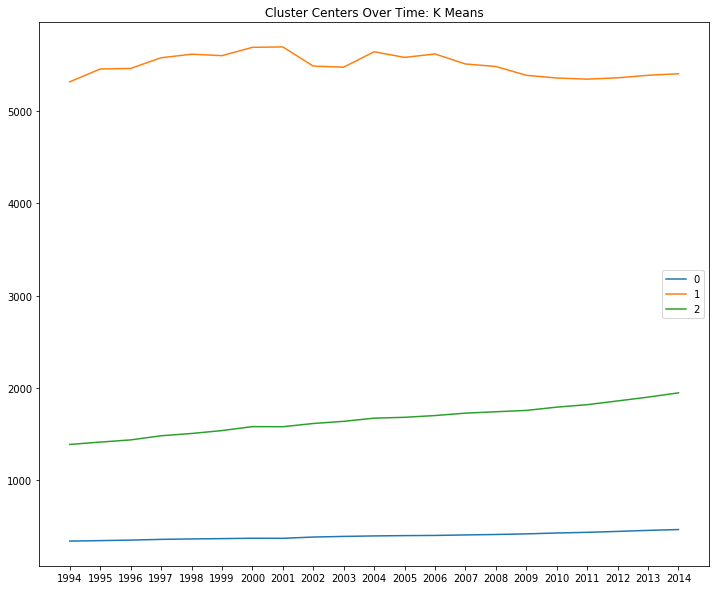

In [25]:
plt.figure(figsize=(12,10))
plt.plot(cluster_label_group.ix[:,0:21].T)
plt.title("Cluster Centers Over Time: K Means")
plt.legend([0,1,2])

In [39]:
# 3 Cluster using gaussian mixture

In [27]:
from sklearn import mixture

In [28]:
g = mixture.GMM(n_components=3)
g.fit(cluster)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [29]:
cluster_labels = g.predict(cluster)

In [30]:
cluster["Cluster_Labels_GaussianMixture"] = cluster_labels

In [31]:
df = df.join(cluster.Cluster_Labels_GaussianMixture)

Text(0.5,1,'Clusters: Gaussian Mixture')

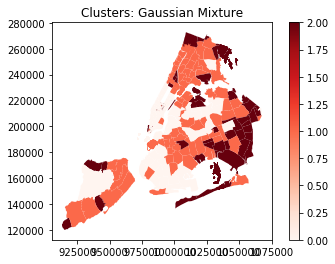

In [32]:
df.plot(column = "Cluster_Labels_GaussianMixture", cmap = "Reds", legend = True)
plt.title("Clusters: Gaussian Mixture")

In [33]:
cluster_label_group_1 = df.groupby("Cluster_Labels_GaussianMixture").mean()

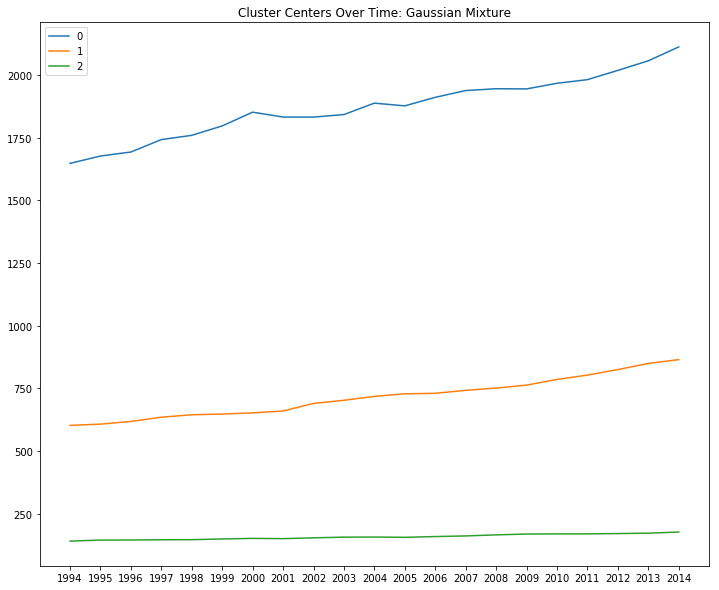

In [34]:
plt.figure(figsize=(12,10))
plt.plot(cluster_label_group_1.ix[:,0:21].T)
plt.title("Cluster Centers Over Time: Gaussian Mixture")
plt.legend([0,1,2])

In [35]:
# interpret

In [40]:
# Cluster: the time series plots have similar shapes, but scales are different 
# Since the features in the cluster are different, perhaps the slope that makes them similar

In [41]:
# Interpretation of one cluster of zip codes in midtown manhattan, and the parallel cluster includes midtown Manhattan 
# and other zip codes in inner parts of the borough. The clusters are seeing the largest number of businesses.
# (and in one cluster the largest growth) since 1994.
# One pair of clusters are those of zipcodes in outer parts of NYC. They have the smallest number of businesses 
# and the smallest rate of growth.
# The final pair of clusters look in between the inner and outer areas of NYC. 
# They have an average number of businesses somewhere in the middle of the two clusters, and depending on the 
# cluster method a growth rate either in the middle or the highest of the three clusters.